In [1]:
from pathlib import Path
from keras import backend as K
import pandas as pd
import numpy as np
import json
import glob
import os
import os
import cv2
import glob
import numpy as np
import pandas as pd
import random
import pickle
from tqdm import tqdm
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
import skimage
from skimage.io import imread
#from vis.visualization import visualize_cam, visualize_cam_with_losses, visualize_activation, visualize_saliency
#from vis.utils import utils
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit as s_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout, Reshape
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop, Adam
from keras.layers import Conv2D , SeparableConv2D, BatchNormalization, UpSampling2D, MaxPool2D, Lambda, concatenate
from keras.layers import MaxPooling2D, Average, Input, Concatenate, LeakyReLU, Add, ELU, PReLU, ReLU, LSTM, add, GRU
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras import backend as BE
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.utils import plot_model
from numpy.random import seed
tf.random.set_seed(1)
import pywt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.io.wavfile as wav
import os
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit as s_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
def get_image_data_train(path):
    X=[]
    y=[]

    for nextDir in os.listdir(path):
        if not nextDir.startswith('.'):
            if nextDir in ['c_28N']:
                label = 0
            elif nextDir in ['c_29N']:
                label = 1
            elif nextDir in ['c_30N']:
                label = 2
            elif nextDir in ['c_31N']:
                label = 3
            elif nextDir in ['c_32N']:
                label = 4
            elif nextDir in ['c_33N']:
                label = 5
            elif nextDir in ['c_34N']:
                label = 6
            elif nextDir in ['c_35N']:
                label = 7
            elif nextDir in ['c_36N']:
                label = 8
            elif nextDir in ['c_37N']:
                label = 9    
            
            temp = path + nextDir
            for file in tqdm(os.listdir(temp)):
                #print(file)
                img = cv2.imread(temp + '/' + file, 1)
                if img is not None:
                    ''' ------------------Segmentation using Clustering-----------------------------
                    im1 = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
                    kmeans = KMeans(n_clusters=5, random_state=0).fit(im1)
                    pic = kmeans.cluster_centers_[kmeans.labels_]
                    img = pic.reshape(img.shape[0], img.shape[1], img.shape[2])
                    cv2.imwrite("segmentedData/"+nextDir+"/"+file,img)
                    '''
                    #clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(16,16))
                    #planes = cv2.split(img)
                    #for i in range(0,3):
                        #planes[i] =clahe.apply(planes[i])
                    #img = cv2.merge(planes)
                    #img = clahe.apply(img)
                    #img = cv2.GaussianBlur(img,(5,5),0)

                    img = cv2.resize(img, (128, 128))

                    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    #img1 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))[0]
                    #img2 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))[0]
                    #img3 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))[1]
                    #img4 = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))[1]
                    #img = cv2.merge([img,img1])
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [3]:
path_train= "ReshapedTomatoImg/"

X_train, y_train = get_image_data_train(path_train)

100%|██████████| 640/640 [00:00<00:00, 2077.50it/s]


<font size=5>The Model Development</font>

In [4]:
def shuffle_data(X_shu, y_shu):
    #X_shu=np.asarray(X_shu)
    #y_shu=np.asarray(y_shu)
    split = s_split(n_splits= 1, test_size = 0.40, random_state=18)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for train_id, test_id in split.split(X_shu, y_shu):
        X_train.append(X_shu[train_id])
        y_train.append(y_shu[train_id])
        X_test.append(X_shu[test_id])
        y_test.append(y_shu[test_id])
    #del X_shu
    #del y_shu
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = shuffle_data(X_train,y_train)
X_train = np.asarray(X_train, dtype = "float32")[0]
X_test = np.asarray(X_test, dtype = "float32")[0]
y_train = np.asarray(y_train)[0]
y_test = np.asarray(y_test)[0]

In [6]:
X_train /= 255
X_test /= 255

In [7]:
y_test = to_categorical(y_test,10)
y_train = to_categorical(y_train,10)

In [8]:
X_test.shape

(2846, 128, 128, 3)

<font size=5>The Model</font>

In [9]:
BE.clear_session()

In [10]:
def model(in_):
    conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(in_)
    batchnorm_1 = BatchNormalization()(conv_1)
    batchnorm_1 = ReLU()(batchnorm_1)
    conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
    batchnorm_2 = BatchNormalization()(conv_2)
    batchnorm_2 = ReLU()(batchnorm_2)
    conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(batchnorm_2)
    batchnorm_3 = BatchNormalization()(conv_3)
    batchnorm_3 = ReLU()(batchnorm_3)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)

    conv_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_3)
    #conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_4)
    batchnorm_4 = BatchNormalization()(conv_4)
    batchnorm_4 = ReLU()(batchnorm_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)

    conv_5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_4)
    batchnorm_5 = BatchNormalization()(conv_5)
    batchnorm_5 = ReLU()(batchnorm_5)
    pool_5 = MaxPooling2D(pool_size=(2, 2))(batchnorm_5)
    
    bn_shape = pool_5.get_shape()  # (?, {dimension}50, {dimension}12, {dimension}256)

    print(bn_shape)  # (?, 50, 7, 512)

    x_reshape = Reshape(target_shape=(int(bn_shape[1]), int(bn_shape[2] * bn_shape[3])))(pool_5)

    fc_1 = Dense(64, activation='relu')(x_reshape)  # (?, 50, 128)

    print(x_reshape.get_shape())  # (?, 50, 3584)
    print(fc_1.get_shape())  # (?, 50, 128)

    rnn_1 = LSTM(64, kernel_initializer="he_normal", return_sequences=True)(fc_1)
    rnn_1b = LSTM(64, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(fc_1)
    rnn1_merged = add([rnn_1, rnn_1b])

    drop_1 = Dropout(0.25)(rnn1_merged)
    
    drop_1 = Flatten()(drop_1)

    fc_2 = Dense(4, kernel_initializer='he_normal', activation='softmax')(drop_1)
    return fc_2

In [10]:
def model(in_):
    conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(in_)
    batchnorm_1 = BatchNormalization()(conv_1)
    batchnorm_1 = ReLU()(batchnorm_1)
    conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
    batchnorm_2 = BatchNormalization()(conv_2)
    batchnorm_2 = ReLU()(batchnorm_2)
    conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(batchnorm_2)
    batchnorm_3 = BatchNormalization()(conv_3)
    batchnorm_3 = ReLU()(batchnorm_3)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)

    conv_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_3)
    #conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_4)
    batchnorm_4 = BatchNormalization()(conv_4)
    batchnorm_4 = ReLU()(batchnorm_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)

    conv_5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_4)
    batchnorm_5 = BatchNormalization()(conv_5)
    batchnorm_5 = ReLU()(batchnorm_5)
    pool_5 = MaxPooling2D(pool_size=(2, 2))(batchnorm_5)
    
    bn_shape = pool_5.get_shape()  # (?, {dimension}50, {dimension}12, {dimension}256)

    print(bn_shape)  # (?, 50, 7, 512)

    x_reshape = Reshape(target_shape=(int(bn_shape[1]), int(bn_shape[2] * bn_shape[3])))(pool_5)

    fc_1 = Dense(64, activation='relu')(x_reshape)  # (?, 50, 128)

    print(x_reshape.get_shape())  # (?, 50, 3584)
    print(fc_1.get_shape())  # (?, 50, 128)

    rnn_1 = GRU(64, kernel_initializer="glorot_uniform", return_sequences=True)(fc_1)
    rnn_1b = GRU(64, kernel_initializer="glorot_uniform", go_backwards=True, return_sequences=True)(fc_1)
    rnn1_merged = add([rnn_1, rnn_1b])

    drop_1 = Dropout(0.25)(rnn1_merged)
    
    drop_1 = Flatten()(drop_1)

    fc_2 = Dense(10, kernel_initializer='glorot_uniform', activation='softmax')(drop_1)
    return fc_2

glorot_uniform 

In [11]:
in_ = Input((128,128,3))
model = model(in_)

(None, 16, 16, 64)
(None, 16, 1024)
(None, 16, 64)


In [12]:
model_f = Model(input = in_, output = model)

/home/tousin/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [13]:
model_f.compile(optimizer = RMSprop(), loss = "binary_crossentropy", metrics=["accuracy"])
model_f.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

<font size=5>Specifying parameters</font>

In [14]:
nb_epochs = 10
nb_batch = 20

#earlyStopping=EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto')

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0002, patience=2, verbose=1)

save_path="weights_11/CRNN_tomato_F5.h5"

checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
history=model_f.fit(X_train, y_train, epochs = nb_epochs, batch_size = nb_batch, callbacks=[lr_reduce, checkpoint], validation_split=.10, verbose = 1)

Train on 3840 samples, validate on 427 samples
Epoch 1/10
3840/3840 [==============================] - 475s 124ms/step - loss: 0.1833 - accuracy: 0.9338 - val_loss: 0.3274 - val_accuracy: 0.9000

Epoch 00001: val_accuracy improved from -inf to 0.90000, saving model to weights_11/CRNN_tomato_F5.h5
Epoch 2/10
3840/3840 [==============================] - 457s 119ms/step - loss: 0.1109 - accuracy: 0.9581 - val_loss: 0.3616 - val_accuracy: 0.8728

Epoch 00002: val_accuracy did not improve from 0.90000
Epoch 3/10
3840/3840 [==============================] - 467s 122ms/step - loss: 0.0837 - accuracy: 0.9674 - val_loss: 0.2409 - val_accuracy: 0.9342

Epoch 00003: val_accuracy improved from 0.90000 to 0.93419, saving model to weights_11/CRNN_tomato_F5.h5
Epoch 4/10
3840/3840 [==============================] - 467s 122ms/step - loss: 0.0706 - accuracy: 0.9739 - val_loss: 0.2269 - val_accuracy: 0.9316

Epoch 00004: val_accuracy did not improve from 0.93419
Epoch 5/10
3840/3840 [==================

In [16]:
with open('history_1/CRNN_tomato_F5', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [12]:
#from keras.models import load_model
#model_f=load_model("weights_11/CRNN_tomato_F5.h5")
model_f.load_weights("weights_11/CRNN_tomato_F5.h5")

In [13]:
model_f.evaluate(X_test,y_test,verbose=2)

[0.04523481525485983, 0.9847856760025024]

<font  size=5>Visualization</font>

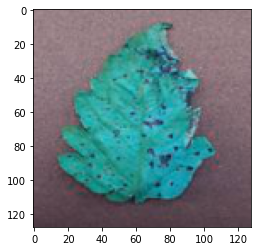

In [18]:
idx=141
plt.imshow(cv2.merge(cv2.split(X_test[idx])[0:3]))

In [19]:
x = np.expand_dims(X_test[idx], axis=0)

In [20]:
model_f.predict(x, verbose=1)[0].argmax(axis=0)

1/1 [==============================] - 1s 849ms/step


4

In [21]:
y_test[idx]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

# CNN without LSTM

In [17]:
def model_cnn(in_):
    conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(in_)
    batchnorm_1 = BatchNormalization()(conv_1)
    batchnorm_1 = ReLU()(batchnorm_1)
    conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
    batchnorm_2 = BatchNormalization()(conv_2)
    batchnorm_2 = ReLU()(batchnorm_2)
    conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(batchnorm_2)
    batchnorm_3 = BatchNormalization()(conv_3)
    batchnorm_3 = ReLU()(batchnorm_3)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)

    conv_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_3)
    #conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_4)
    batchnorm_4 = BatchNormalization()(conv_4)
    batchnorm_4 = ReLU()(batchnorm_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)

    conv_5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_4)
    batchnorm_5 = BatchNormalization()(conv_5)
    batchnorm_5 = ReLU()(batchnorm_5)
    pool_5 = MaxPooling2D(pool_size=(2, 2))(batchnorm_5)
    
    bn_shape = pool_5.get_shape()  # (?, {dimension}50, {dimension}12, {dimension}256)

    print(bn_shape)  # (?, 50, 7, 512)

    x_reshape = Reshape(target_shape=(int(bn_shape[1]), int(bn_shape[2] * bn_shape[3])))(pool_5)

    fc_1 = Dense(64, activation='relu')(x_reshape)  # (?, 50, 128)

    print(x_reshape.get_shape())  # (?, 50, 3584)
    print(fc_1.get_shape())  # (?, 50, 128)

    #rnn_1 = LSTM(64, kernel_initializer="he_normal", return_sequences=True)(fc_1)
    #rnn_1b = LSTM(64, kernel_initializer="he_normal", go_backwards=True, return_sequences=True)(fc_1)
    #rnn1_merged = add([rnn_1, rnn_1b])

    drop_1 = Dropout(0.25)(fc_1)
    
    drop_1 = Flatten()(drop_1)

    fc_2 = Dense(10, kernel_initializer='glorot_uniform', activation='softmax')(drop_1)
    return fc_2

In [18]:
in_ = Input((128,128,3))
model_c = model_cnn(in_)

(None, 16, 16, 64)
(None, 16, 1024)
(None, 16, 64)


In [19]:
model_f_cnn = Model(input = in_, output = model_c)

/home/tousin/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [20]:
model_f_cnn.compile(optimizer = RMSprop(), loss = "binary_crossentropy", metrics=["accuracy"])
model_f_cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
re_lu_6 (ReLU)               (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 128, 128, 32)      0   

In [21]:
nb_epochs = 10
nb_batch = 20

#earlyStopping=EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='auto')

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

save_path="weights_22/CNN_tomato_F5.h5"

checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [22]:
history_c=model_f_cnn.fit(X_train, y_train, epochs = nb_epochs, batch_size = nb_batch, callbacks=[lr_reduce, checkpoint], validation_split=.10, verbose = 1)

Train on 3840 samples, validate on 427 samples
Epoch 1/10
3840/3840 [==============================] - 463s 121ms/step - loss: 0.1988 - accuracy: 0.9306 - val_loss: 0.3249 - val_accuracy: 0.9000

Epoch 00001: val_accuracy improved from -inf to 0.90000, saving model to weights_22/CNN_tomato_F5.h5
Epoch 2/10
3840/3840 [==============================] - 434s 113ms/step - loss: 0.1174 - accuracy: 0.9554 - val_loss: 0.3234 - val_accuracy: 0.8953

Epoch 00002: val_accuracy did not improve from 0.90000
Epoch 3/10
3840/3840 [==============================] - 433s 113ms/step - loss: 0.0905 - accuracy: 0.9657 - val_loss: 0.2436 - val_accuracy: 0.9293

Epoch 00003: val_accuracy improved from 0.90000 to 0.92927, saving model to weights_22/CNN_tomato_F5.h5
Epoch 4/10
3840/3840 [==============================] - 434s 113ms/step - loss: 0.0797 - accuracy: 0.9704 - val_loss: 0.2730 - val_accuracy: 0.9344

Epoch 00004: val_accuracy improved from 0.92927 to 0.93443, saving model to weights_22/CNN_tomato

In [23]:
with open('history_2/CNN_tomato_F5', 'wb') as file_pi:
    pickle.dump(history_c.history, file_pi)

In [30]:
model_f_cnn.load_weights("weights_2/CNN_rice_leaf_aug_1.h5")

In [31]:
model_f_cnn.evaluate(X_test,y_test,verbose=2)

[0.44551852483152454, 0.7906110286712646]

In [27]:
from scipy.misc import imresize
from vis.visualization import visualize_cam, visualize_cam_with_losses, visualize_activation, visualize_saliency
from vis.utils import utils
#from scipy.misc import imresize
plt.imshow(visualize_cam(model=model_f, layer_idx=utils.find_layer_idx(model_f, 're_lu_5'), filter_indices=None, seed_input=np.asarray(X_test[idx]), penultimate_layer_idx=utils.find_layer_idx(model_f, 'batch_normalization_5'), \
    backprop_modifier=None, grad_modifier=None))

ImportError: cannot import name 'imresize'

<font size =  5>The performance metrics</font>

In [28]:
y_pred = model_f.predict([X_test])
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [9]:
from keras.models import load_model
model_cf=load_model("weights_11/CRNN_tomato_F5.h5")
y_pred = model_cf.predict([X_test])
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [10]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[10,10], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible = False
        t.tick2line.set_visible = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.savefig("confusion_matrix_tomato/conf_mat_5.png", transparent=True, dpi=fig.dpi)
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[20,20], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[20,20];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#

In [11]:
df_cm = pd.DataFrame(matrix, index=range(1,11), columns=range(1,11))

/home/tousin/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


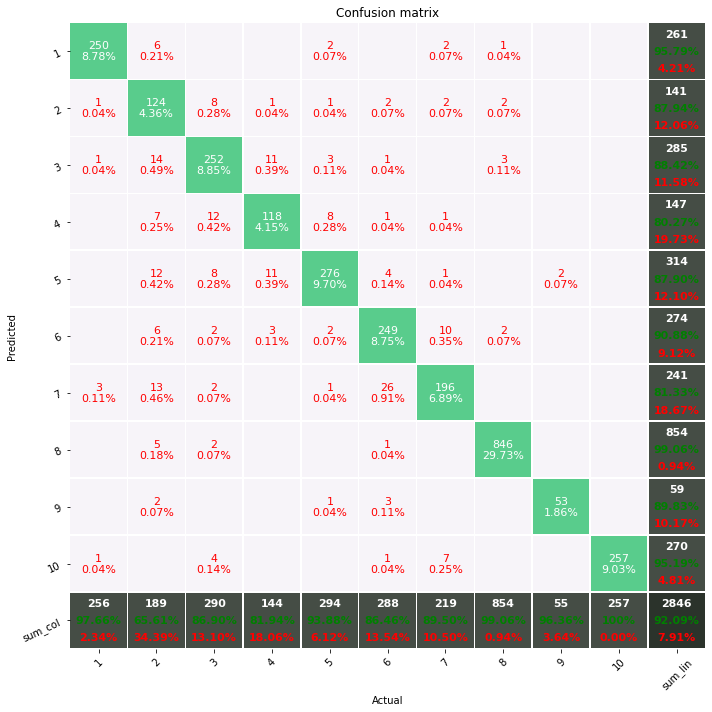

In [12]:
cmap = 'PuRd'
pretty_plot_confusion_matrix(df_cm, cmap=cmap)

In [13]:
from IPython.core.display import HTML
display(HTML(df_cm.to_html()))

,1,2,3,4,5,6,7,8,9,10
1,250,1,1,0,0,0,3,0,0,1
2,6,124,14,7,12,6,13,5,2,0
3,0,8,252,12,8,2,2,2,0,4
4,0,1,11,118,11,3,0,0,0,0
5,2,1,3,8,276,2,1,0,1,0
6,0,2,1,1,4,249,26,1,3,1
7,2,2,0,1,1,10,196,0,0,7
8,1,2,3,0,0,2,0,846,0,0
9,0,0,0,0,2,0,0,0,53,0
10,0,0,0,0,0,0,0,0,0,257


In [45]:
print(y_test)
print(y_pred_probs.argmax(axis=1))
print(y_pred_probs[:,1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[5 9 7 ... 5 1 9]
[1.7316264e-04 4.1541002e-06 9.2833434e-06 ... 1.1228941e-06 9.9851996e-01
 1.8714609e-07]


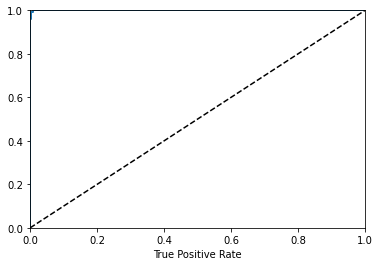

In [23]:
y_pred_probs = model_f.predict([X_test])
#print(y_pred_probs)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])
fpr, tpr, thresholds = roc_curve(y_test[:,0], y_pred_probs[:,0])
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.xlabel("True Positive Rate")

plot_roc_curve(fpr, tpr)
plt.show()
#roc_auc_score(y_test,y_pred_probs)

In [27]:
filename = open('history_2/CNN_tomato_F1',"rb")
history1 = pickle.load(filename)
filename = open('history_2/CNN_tomato_F2',"rb")
history2 = pickle.load(filename)
filename = open('history_2/CNN_tomato_F3',"rb")
history3 = pickle.load(filename)
filename = open('history_2/CNN_tomato_F4',"rb")
history4 = pickle.load(filename)
filename = open('history_2/CNN_tomato_F5',"rb")
history5 = pickle.load(filename)

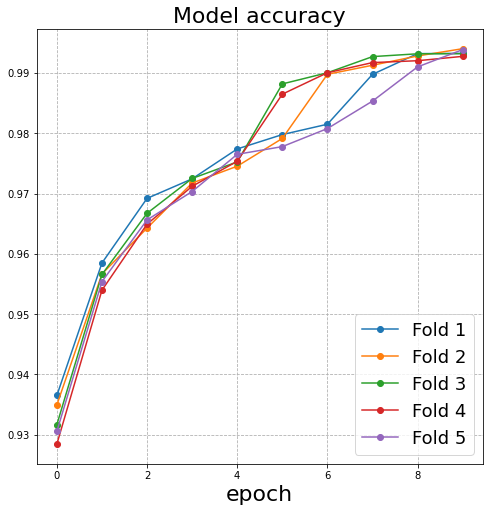

In [28]:
fig = plt.figure(figsize=(8,8))
plt.plot(history1['accuracy'], marker='o', label='Fold 1')
plt.plot(history2['accuracy'], marker='o', label='Fold 2')
plt.plot(history3['accuracy'], marker='o', label='Fold 3')
plt.plot(history4['accuracy'], marker='o', label='Fold 4')
plt.plot(history5['accuracy'], marker='o', label='Fold 5')
plt.title('Model accuracy', fontsize='22')
plt.xlabel('epoch', fontsize='22')
plt.legend(loc='lower right', title_fontsize = 20, prop={'size':18})
plt.grid(linestyle='--')
plt.show()
fig.savefig('CNN_tomato_graphs/acc_model.png', dpi = fig.dpi, transparent=True)

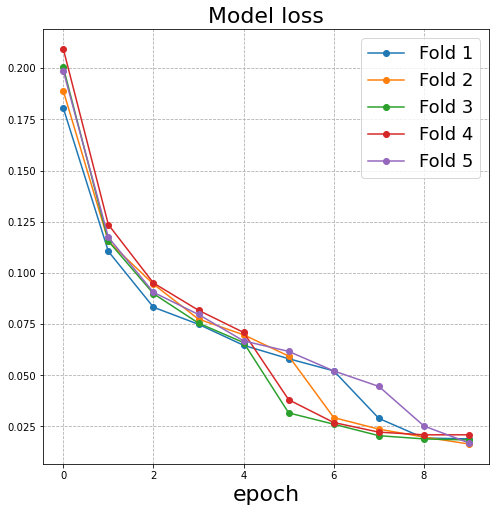

In [29]:
fig = plt.figure(figsize=(8,8))
plt.plot(history1['loss'], marker='o', label='Fold 1')
plt.plot(history2['loss'], marker='o', label='Fold 2')
plt.plot(history3['loss'], marker='o', label='Fold 3')
plt.plot(history4['loss'], marker='o', label='Fold 4')
plt.plot(history5['loss'], marker='o', label='Fold 5')
plt.title('Model loss', fontsize='22')
plt.xlabel('epoch', fontsize='22')
plt.legend(loc='upper right', title_fontsize = 20, prop={'size':18})
plt.grid(linestyle='--')
plt.show()
fig.savefig('CNN_tomato_graphs/loss_model.png', dpi = fig.dpi, transparent=True)

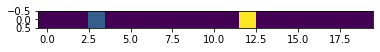

In [41]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
model = model_f
# redefine model to output right after the first hidden layer
#model_f.summary()
# load the image with the required shape
# expand dimensions so that it represents a single 'sample'
img = expand_dims(X_test[15], axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
pyplot.imshow(feature_maps)